### Traffic forecasting using graph neural networks and LSTM

ORIGINAL LINK: https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

Author: [Arash Khodadadi](https://www.linkedin.com/in/arash-khodadadi-08a02490/)

Date created: 2021/12/28

Last modified: 2023/11/22

This example demonstrates how to do timeseries forecasting over graphs.

Accelerator: GPU

#### Introduction

This notebook shows how to forecast traffic conditions using a NeuralNet model with LSTM.

Specifically, it uses a novel approach to predict future values of traffic speed given a history of traffic speed for a collection of road segments.

A method commonlyh used to solve problems like this is to consider each road segment's traffic speed as an independet timeseries and predict
the future values of each timeseries using the past values of the same timeseries.

The method presented here, however, ignores the dependency of the traffic speed of one road segment on neighboring segments.

To be able to take into account the complex interactions between the traffic speed on a collection of neighboring roads, 
the model represents the traffic network as a graph, and consider the traffic speed as a signal on this graph.

In this noteboook a NN model is presented that can process timeseries data over a graph.

The first step is to show how to process the data to create a TF Data set:

[tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) 

for forecasting over graphs. Then, we implement a model which uses graph convolution and LSTM layers to perform forecasting over the graph.

The data processing and the model architecture are inspired by this paper:

Yu, Bing, Haoteng Yin, and Zhanxing Zhu. "Spatio-temporal graph convolutional networks:
a deep learning framework for traffic forecasting." Proceedings of the 27th International
Joint Conference on Artificial Intelligence, 2018.
([github](https://github.com/VeritasYin/STGCN_IJCAI-18))


## Paper Abstract (from the original paper)

Timely accurate traffic forecast is crucial for urban traffic control and guidance. Due to the high nonlinearity and complexity of traffic flow, traditional methods cannot satisfy the requirements of mid-and-long term prediction tasks and often neglect spatial and temporal dependencies.

In this paper, we propose a novel deep learning framework, **Spatio-Temporal Graph Convolutional Networks (STGCN)**, to tackle the time series prediction problem in traffic domain. 

Instead of applying regular convolutional and recurrent units, we formulate the problem on graphs and build the model with complete convolutional structures, which enable much faster training speed with fewer parameters. Experiments show that our model STGCN effectively captures comprehensive spatio-temporal correlations through modeling multi-scale traffic networks and consistently outperforms state-of-the-art baselines on various real-world traffic datasets. 

Transportation plays a vital role in everybody’s daily life. According to a survey in 2015, U.S. drivers spend about 48 minutes on average behind the wheel daily.1 Under this circumstance, accurate real-time forecast of traffic conditions is of paramount importance for road users, private sectors and governments. 

Widely used transportation services, such as flow control, route planning, and navigation, also rely heavily on a high-quality traffic condition evaluation. In general, multiscale traffic forecast is the premise and foundation of urban traffic control and guidance, which is also one of main functions of the Intelligent Transportation System (ITS). In the traffic study, fundamental variables of traffic flow, namely speed, volume, and density are typically chosen as indicators to monitor the current status of traffic conditions an


## Datasets

We verify our model on two real-world traffic datasets, BJER4 and PeMSD7, collected by Beijing Municipal Traffic Commission and the California Department of Transportation, respectively. 

Each dataset contains key attributes of traffic observations and geographic information with corresponding timestamps, as detailed below. 

BJER4 was gathered from the major areas of east ring No.4 routes in Beijing City by double-loop detectors. There are 12 roads selected for our experiment. The traffic data are aggregated every 5 minutes. The time period used is from 1st July to 31st August, 2014 except the weekends. We select the first month of historical speed records as training set, and the rest serves as validation and test set respectively. 

PeMSD7 was collected from Caltrans Performance Measurement System (PeMS) in real-time by over 39, 000 sensor stations, deployed across the major metropolitan areas of California state highway system [Chen et al., 2001]. The dataset is also aggregated into 5-minute interval from 30-second data samples. We randomly select a medium and a large scale among the District 7 of California containing 228 and 1, 026 stations, labeled as PeMSD7(M) and PeMSD7(L), respectively, as data sources (shown in the left of Figure 3). The time range of PeMSD7 dataset is in the weekdays of May and June of 2012. We split the training and test sets based on the same principles as above.

In [ ]:
# GET THE APIs
import os 
import pandas as pd
import numpy as np
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras import ops

## Data preparation

### Data description

We use a real-world traffic speed dataset named `PeMSD7`. We use the version
collected and prepared by [Yu et al., 2018](https://arxiv.org/abs/1709.04875)
and available
[here](https://github.com/VeritasYin/STGCN_IJCAI-18/tree/master/dataset).

The data consists of two files:

- `PeMSD7_W_228.csv` contains the distances between 228
stations across the District 7 of California.
- `PeMSD7_V_228.csv` contains traffic
speed collected for those stations in the weekdays of May and June of 2012.

The full description of the dataset can be found in
[Yu et al., 2018](https://arxiv.org/abs/1709.04875).


I uploaded the data into /drv3/hm3/code/python/tf2.19/local/Traffic_Forecasting_Data/



In [4]:
## Loading the data

#url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"
#data_dir = keras.utils.get_file(origin=url, extract=True, archive_format="zip")
#data_dir = data_dir.rstrip("PeMSD7_Full.zip")

data_dir = "/drv3/hm3/code/python/tf2.19/local/Traffic_Forecasting_Data/"
route_distances = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_W_228.csv"), header=None
).to_numpy()
speeds_array = pd.read_csv(
    os.path.join(data_dir, "PeMSD7_V_228.csv"), header=None
).to_numpy()

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


In [29]:
df1 = pd.DataFrame( route_distances )
df1.describe( ) 


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,...,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,5053.025000,4760.395385,7355.307308,4672.478462,5855.178846,5015.466923,5522.504615,7358.940769,6643.327692,9383.103077,...,4958.791154,4704.993462,6611.218077,4773.924231,5956.958077,6599.522692,5961.819615,5597.529615,5295.789231,7163.838462
std,2293.813674,3341.210348,4786.623963,2896.340458,4605.806017,4034.071691,4459.115543,4560.423876,3878.511538,5322.768843,...,3953.393040,2627.331343,5104.490812,3569.595212,4860.615968,5104.287365,4858.060322,4427.341009,4403.552167,3973.761351
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3273.795000,2172.720000,3753.372500,2463.190000,2624.802500,1803.862500,2431.522500,2664.095000,3356.425000,4209.732500,...,2118.705000,2874.242500,2889.132500,2118.167500,2327.422500,2868.607500,2345.907500,2172.532500,2145.257500,3577.970000
50%,5321.470000,3781.325000,5343.550000,4186.830000,3501.310000,3389.775000,3195.325000,8409.655000,7155.350000,10948.630000,...,3006.710000,4664.735000,4922.410000,3420.815000,4162.650000,4907.530000,4176.195000,3936.595000,2967.885000,7648.150000
75%,6492.197500,7316.367500,11921.460000,6422.592500,10218.725000,8638.527500,9703.680000,11270.657500,10013.210000,13805.495000,...,8405.857500,6350.477500,11397.247500,7643.820000,10482.462500,11386.920000,10482.417500,9609.502500,9403.447500,10707.290000
max,9382.320000,11646.700000,16147.630000,10672.810000,14521.760000,12976.630000,14015.510000,13478.020000,12273.060000,15943.740000,...,12810.690000,10033.760000,15807.470000,12044.900000,14892.730000,15797.030000,14892.760000,14018.490000,13745.710000,12496.860000


### sub-sampling roads

To reduce the problem size and make the training faster, we use only a sample of 26 roads out of the 228 roads in the dataset.

We have chosen the roads by starting from road 0, choosing the 5 closest roads to it, and continuing this process until we get 25 roads.
You can choose any other subset of the roads. We chose the roads in this way to increase the likelihood of having roads with correlated speed timeseries.
`sample_routes` contains the IDs of the selected roads.

In [5]:

sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]
route_distances = route_distances[np.ix_(sample_routes, sample_routes)]
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")


route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


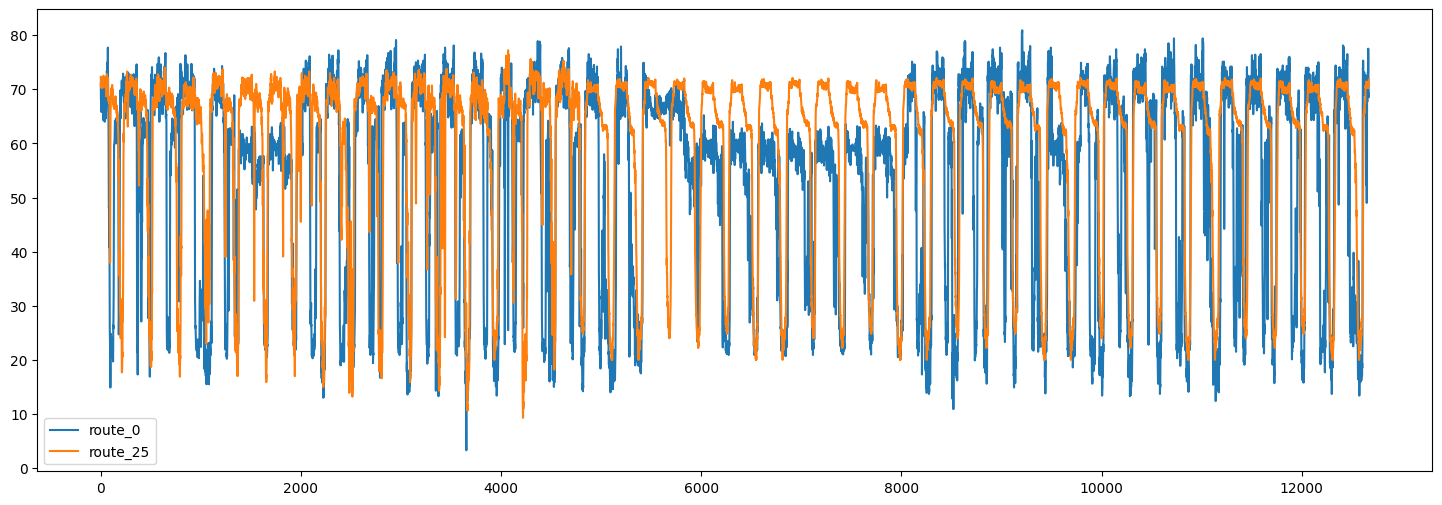

In [ ]:
# Below are the timeseries of the traffic speed for two of the routes:

plt.figure(figsize=(18, 6))
plt.plot(speeds_array[:, [0, -1]])
plt.legend(["route_0", "route_25"])

Text(0, 0.5, 'road number')

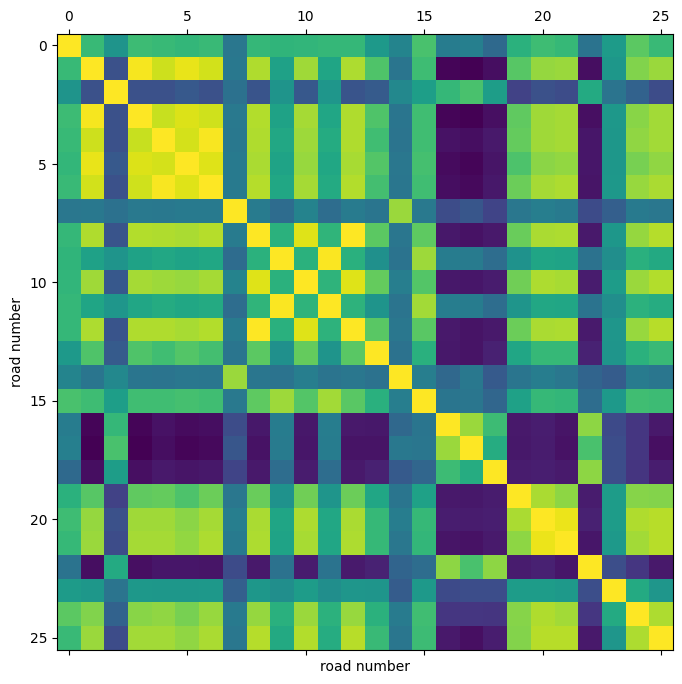

In [ ]:
# We can also visualize the correlation between the timeseries in different routes.
# Using this correlation heatmap, we can see that the speeds in routes 4, 5, 6 are highly correlated.

plt.figure(figsize=(8, 8))
plt.matshow(np.corrcoef(speeds_array.T), 0)
plt.xlabel("road number")
plt.ylabel("road number")


In [ ]:

# Next, we split the speed values array into train/validation/test sets,
# and normalize the resulting arrays:

train_size, val_size = 0.5, 0.2

def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array

In [9]:
train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


### Creating TensorFlow Datasets

Next, we create the datasets for our forecasting problem. The forecasting problem
can be stated as follows: given a sequence of the road speed values at times `t+1, t+2, ..., t+T`,

we want to predict the future values of the roads speed for times `t+T+1, ..., t+T+h`.
So for each time `t` the inputs to our model are `T` vectors each of size `N` and the targets are `h` vectors each of size `N`,
where `N` is the number of roads.

We use the Keras built-in function `keras.utils.timeseries_dataset_from_array`.

The function `create_tf_dataset()` below takes as input a `numpy.ndarray` and returns a
`tf.data.Dataset`. 

In this function `input_sequence_length=T` and `forecast_horizon=h`.

The argument `multi_horizon` needs more explanation. Assume `forecast_horizon=3`.

If `multi_horizon=True` then the model will make a forecast for time steps
`t+T+1, t+T+2, t+T+3`. So the target will have shape `(T,3)`. 

But if `multi_horizon=False`, the model will make a forecast only for time step `t+T+3` and
so the target will have shape `(T, 1)`.

You may notice that the input tensor in each batch has shape
`(batch_size, input_sequence_length, num_routes, 1)`.

The last dimension is added to make the model more general: at each time step, the input features for each raod may
contain multiple timeseries. For instance, one might want to use temperature timeseries
in addition to historical values of the speed as input features. 

In this example, however, the last dimension of the input is always 1.

We use the last 12 values of the speed in each road to forecast the speed for 3 time
steps ahead:


In [10]:

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False

In [11]:

def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = keras.utils.timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = keras.utils.timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


In [12]:
train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

I0000 00:00:1742419737.815902   14739 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9087 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:08:00.0, compute capability: 8.6


In [13]:
test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)


### Roads Graph

We assume that the road segments form a graph.

The `PeMSD7` dataset has the road segments distance. The next step is to create the graph adjacency matrix from these distances.

Following [Yu et al., 2018](https://arxiv.org/abs/1709.04875) (equation 10) 

we assume there is an edge between two nodes in the graph if the distance between the corresponding roads
is less than a threshold.

In [14]:

def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask



The function `compute_adjacency_matrix()` returns a boolean adjacency matrix
where 1 means there is an edge between two nodes. 

We use the following class to store the information about the graph.


In [15]:


class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


In [16]:

sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")


number of nodes: 26, number of edges: 150


## Network architecture

Our model for forecasting over the graph consists of a graph convolution
layer and a LSTM layer.

### Graph convolution layer

Our implementation of the graph convolution layer resembles the implementation in 
[this Keras example](https://keras.io/examples/graph/gnn_citations/).

Note that in that example input to the layer is a 2D tensor of shape `(num_nodes,in_feat)`
but in our example the input to the layer is a 4D tensor of shape `(num_nodes, batch_size, input_seq_length, in_feat)`.

The graph convolution layer performs the following steps:

- The nodes' representations are computed in `self.compute_nodes_representation()`
by multiplying the input features by `self.weight`
- The aggregated neighbors' messages are computed in `self.compute_aggregated_messages()`
by first aggregating the neighbors' representations and then multiplying the results by
`self.weight`
- The final output of the layer is computed in `self.update()` by combining the nodes
representations and the neighbors' aggregated messages


In [17]:

class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return ops.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return ops.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = ops.concatenate([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)


### LSTM plus graph convolution

By applying the graph convolution layer to the input tensor, we get another tensor
containing the nodes' representations over time (another 4D tensor). For each time
step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors
but also we need to process the information over time. To this end, we can pass each
node's tensor through a recurrent layer. The `LSTMGC` layer below, first applies
a graph convolution layer to the inputs and then passes the results through a
`LSTM` layer.



In [18]:

class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = ops.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = ops.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = ops.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = ops.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return ops.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)



## Model training


In [19]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

In [20]:

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)


In [21]:
model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)

In [22]:
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20


I0000 00:00:1742419915.036178   15211 service.cc:152] XLA service 0x77261c008800 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742419915.036194   15211 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-03-19 17:31:55.381249: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742419915.710487   15211 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-03-19 17:31:57.367549: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 4484 bytes spill stores, 4408 bytes spill loads

2025-03-19 17:31:57.499719: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35_

38/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7503

I0000 00:00:1742419918.645882   15211 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6860

2025-03-19 17:32:00.028994: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 80 bytes spill stores, 80 bytes spill loads

2025-03-19 17:32:00.033964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 4 bytes spill stores, 8 bytes spill loads

2025-03-19 17:32:00.101705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 208 bytes spill stores, 208 bytes spill loads

2025-03-19 17:32:00.117438: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_35', 192 bytes spill stores, 192 bytes spill loads

2025-03-19 17:32:00.250091: I external/local_x

99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.6773 - val_loss: 0.2866
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2430 - val_loss: 0.1648
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1498 - val_loss: 0.1215
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1194 - val_loss: 0.1011
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1017 - val_loss: 0.0889
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0904 - val_loss: 0.0817
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0844 - val_loss: 0.0787
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0814 - val_loss: 0.0769
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0795 - val_loss: 0.0763
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0783 - val_loss: 0.0772
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0775 - val_loss: 0.0767
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0768 - val_loss: 0.0762


## Making forecasts on test set

Now we can use the trained model to make forecasts for the test set. 

Below, we compute the MAE of the model and compare it to the MAE of naive forecasts.

The naive forecasts are the last value of the speed for each node.


119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
naive MAE: 0.13472308593195767, model MAE: 0.1283232138938219


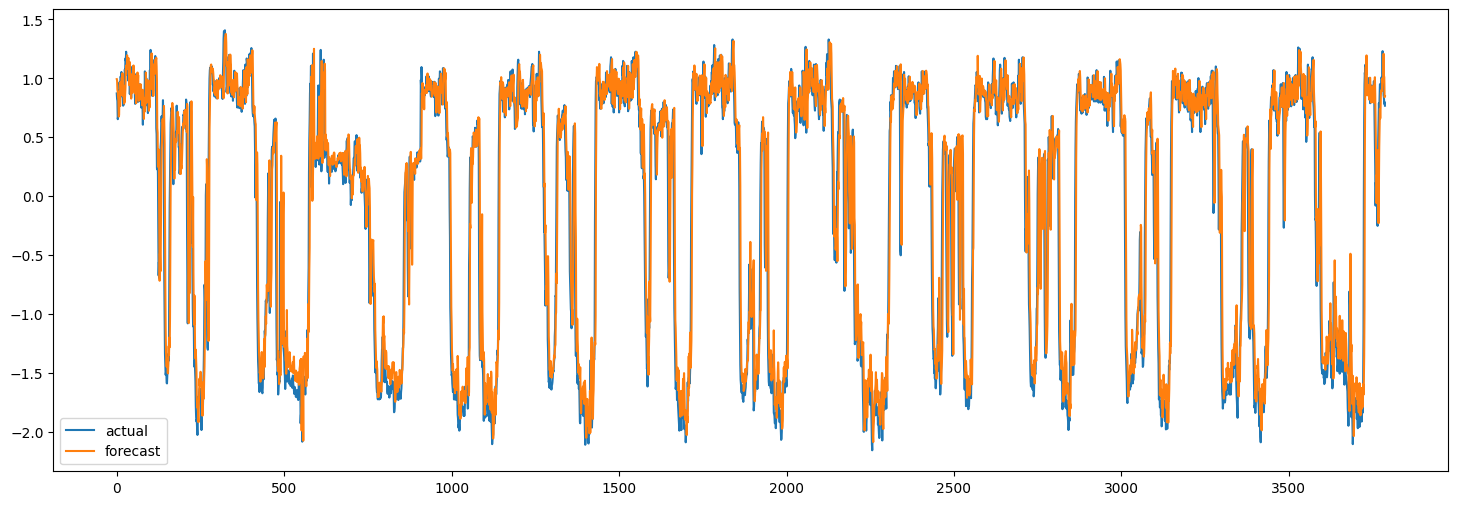

In [23]:

x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")


### Conclussions

Of course, the goal here is to demonstrate the method, not to achieve the best performance.
To improve the model's accuracy, all model hyperparameters should be tuned carefully.

In addition, several of the `LSTMGC` blocks can be stacked to increase the representation power
of the model.